# Genetic Algorithm Blai Ras  (Ex09)

In [89]:
import math
import random
import copy
import numpy as np
import matplotlib.pyplot as plt

In [125]:
#Class defining a chromosome like
#[1 0 1 0 1 0 1 0 1 0 1 1 0 1 1 0 1 0 0 1 0 1 0 1]
class Chromosome:
    def __init__(self, constraints, precision):
        #Representation of x, y
        self.x = 1
        self.y = 1
        #Fitness after calling f(x,y)
        self.fitness = 0
        #Binary strings of x and y
        self.binX = ""
        self.binY = ""
        #Constraints of the problem
        self.constraints = constraints
        
        #Look at the bits needed
        startTempX = (constraints[0][1] - constraints[0][0]) * precision
        self.lenX  = math.ceil(math.log(startTempX,2))
        startTempY = (constraints[1][1] - constraints[1][0]) * precision
        self.lenY  = math.ceil(math.log(startTempY,2))
        
        #Initiate the chromosome construction and check its fitness
        self.random_start()
        self.f()
    
    #Starts generating chromosomes randomly choosing between 0 and 1
    def random_start(self):
        for i in range(self.lenX):
            self.binX += str(random.randint(0,1))
        for i in range(self.lenY):
            self.binY += str(random.randint(0,1))
    
    #Computes its representation given a binary number to a decimal number
    def representation(self,binX,binY):
        self.x = self.constraints[0][0] + int(binX,2) * (self.constraints[0][1] - self.constraints[0][0]) / (2**self.lenX-1)
        self.y = self.constraints[1][0] + int(binY,2) * (self.constraints[1][1] - self.constraints[1][0]) / (2**self.lenY-1)
    
    #Returns the function value given two coordinates
    def f(self):
        self.representation(self.binX,self.binY)
        self.fitness = 21.5 + self.x + math.sin(4*math.pi*self.x)+ self.y * math.sin(20*math.pi*self.y)

In [151]:
#Manages the genetic procedure
class GeneticAlgorithm:
    def __init__(self, constraints, precision, pm, pc, size, generations,stop):
        #Constraints of the problem
        self.constraints = constraints
        #Probability of mutation
        self.pm = pm
        #Probability of crossOvering
        self.pc = pc
        #Number of iterations or generations to "generate"
        self.generations = generations
        #Size of each generation
        self.size = size
        #Precision requested
        self.precision = precision
        
        self.population = []
        self.bests = [0] * generations
        self.best = 0
        #Stopping criterion if no improvement is found
        self.stop = stop
    
    #Initiates the algorithm procedure
    def start(self):
        self.init()
        best = self.getBest()
        
        self.best = copy.deepcopy(best)
        bestFitnesses = [0] * self.generations
        
        noImprovement = 0
        
        for i in range(self.generations):
            #Various operators
            self.crossOver()
            self.mutation()
            self.wheel()
            #Get the best of each generation
            best = self.getBest()
            self.bests[i] = best
            #Does it have a new best?
            if self.best.fitness < best.fitness:
                self.best = copy.deepcopy(best)
                print("New best found at Generation",i,"with value:",self.best.fitness)
                noImprovement = 0
            bestFitnesses[i] = self.best.fitness
            noImprovement +=1

        #Plot the algorithm convergance 
        plt.figure()
        x = range(self.generations)
        plt.plot(x,bestFitnesses)
        plt.xlabel('# of Generations')
        plt.ylabel('Function value')
        plt.show()
    
    #Initates each chromosome generated
    def init(self):
        for i in range(self.size):
            c = Chromosome(self.constraints,self.precision)
            self.population.append(c)
        
    #Operator crossOver
    def crossOver(self):
        #Get pairs
        for i in range(int(self.size / 2)):
            #Return the next random floating point number in the range [0.0, 1.0).
            if self.pc > random.random():
                i = 0
                j = 0
                #Ensuring not the same chromosome
                while i == j:
                    i = random.randint(0,self.size-1)
                    j = random.randint(0,self.size-1)
                c1 = self.population[i]
                c2 = self.population[j]
                #Generate two indices to split. The first will split the "x" part of the chromose
                #And the other one will split the "y" part of chromosome bits
                pos1 = random.randint(0,c1.lenX-1)
                pos2 = random.randint(0,c2.lenY-1)
                
                newC1BinX = c1.binX[:pos1] + c2.binX[pos1:] 
                newC1BinY = c1.binY[:pos2] + c2.binY[pos2:]
                
                newC2BinX = c2.binX[:pos1] + c1.binX[pos1:]
                newC2BinY = c2.binY[:pos2] + c2.binY[pos2:]
                
                c1.binX = newC1BinX
                c1.binY = newC1BinY
                c2.binX = newC2BinX
                c2.binY = newC2BinY
        
    #Operator mutation
    def mutation(self):
        #For each chromosome
        for i in range(self.size):
            #If probability is matched
            if self.pm > random.random():
                c = self.population[i]
                #I change a bit in the X and in the Y part of the chromosome bits
                indexX = random.randint(0,c.lenX-1)
                indexY = random.randint(0,c.lenY-1)

                bit = int(c.binX[indexX])
                bit = str(1 - bit)
                
                c.binX = c.binX[:indexX] + bit + c.binX[indexX+1:]
                
                bit = int(c.binY[indexY])
                bit = str(1 - bit)

                c.binY = c.binY[:indexY] + bit + c.binY[indexY+1:]

    #Operator wheel
    def wheel(self):
        
        min_ = self.population[0].fitness
        for i in range(self.size):
            self.population[i].f()
            
        
        for i in range(self.size):
            if self.population[i].fitness < min_:
                min_ = self.population[i].fitness
                
        #Ensuring fitness > 0
        if min_ < 0:
            for i in range(self.size):
                self.population[i].fitness = self.population[i].fitness + (-1) * min_
                
        #wheel
        #Compute the overall fitness
        totalFitness = 0
        for i in range(self.size):
            totalFitness += self.population[i].fitness
        
        #Computing distributed probability
        probs = [0] * self.size
        for i in range(self.size):
            probs[i] = self.population[i].fitness / totalFitness
        
        cumulative = [0] * self.size
        
        cumulative[0] = 0
        
        for i in range(self.size):
            sum_ = 0
            for j in range(0,i+1):
                sum_+= probs[j]
            cumulative[i] = sum_
        
        #Spin
        selected = []
        for i in range(self.size):
            prob = random.random()
            if prob < cumulative[0]:
                selected.append(self.population[0])
            for j in range(1,self.size):
                if cumulative[j-1] < prob <= cumulative[j]:
                    selected.append(self.population[j])
                    
        self.population = selected
    
    #Returns the best chromosome of the population
    def getBest(self):
        best = copy.deepcopy(self.population[0])
        for i in range(self.size):
            if best.fitness < self.population[i].fitness:
                best = copy.deepcopy(self.population[i])
        return best

In [140]:
constraints = [[-3,12.11], [4.1,5.8]]
precision = 10000

# TESTS

Initial test, with the parameters indicated in the PDF:

New best found at Generation 4 with value: 35.758199976393776
New best found at Generation 5 with value: 36.61928707437443
New best found at Generation 8 with value: 38.76215962222491


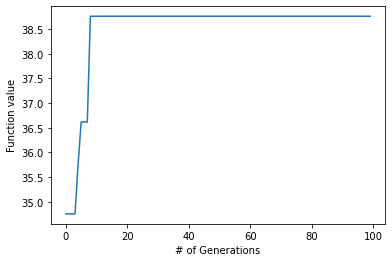

In [156]:
generations = 100
popSize = 50
noImprovementMax = 101

ga = GeneticAlgorithm(constraints, precision,0.01,0.25,popSize,generations,noImprovementMax)
ga.start()

Wolfram says that the maximum is at ~38.5 so overall a perfect run!!

Take in consideration that the output may change due to randomness.

Let's change some parameters, for example, the probabilities and the number of generations or population size:

New best found at Generation 8 with value: 37.85271392593101
New best found at Generation 34 with value: 38.28107174011761
New best found at Generation 45 with value: 38.49312830166831


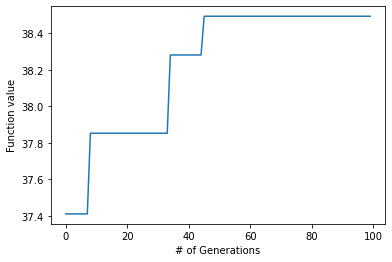

In [158]:
generations = 100
popSize = 100
noImprovementMax = 101

ga = GeneticAlgorithm(constraints, precision,0.01,0.3,popSize,generations,noImprovementMax)
ga.start()

One of my best results so far!!

For pure testing, let's heavily increment the number of iterations. Take in consideration that I let the algorithm iterate because I set the stopping criterion bigger than the generation number.

New best found at Generation 0 with value: 37.98149309132094
New best found at Generation 3 with value: 39.13549885653457
New best found at Generation 6 with value: 39.16246341278638
New best found at Generation 1124 with value: 39.206606437963785
New best found at Generation 5709 with value: 39.70949661438327


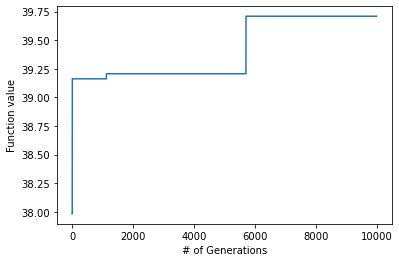

New best found at Generation 6 with value: 36.90791239529421
New best found at Generation 10 with value: 37.708264779509186
New best found at Generation 19 with value: 38.15885605987829
New best found at Generation 20 with value: 38.59622865589373
New best found at Generation 264 with value: 39.09426998233541
New best found at Generation 1128 with value: 39.32513998274886
New best found at Generation 1977 with value: 39.89820178697343


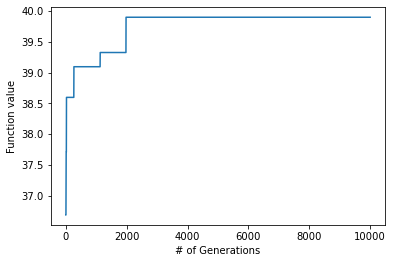

New best found at Generation 5 with value: 38.274545784329916
New best found at Generation 1413 with value: 38.63746211944463
New best found at Generation 3121 with value: 39.62404997254973
New best found at Generation 7845 with value: 40.26439839038535


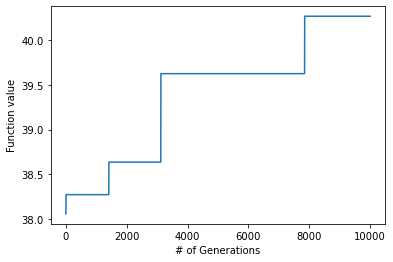

New best found at Generation 225 with value: 39.49416482653127
New best found at Generation 4612 with value: 39.557249871452186


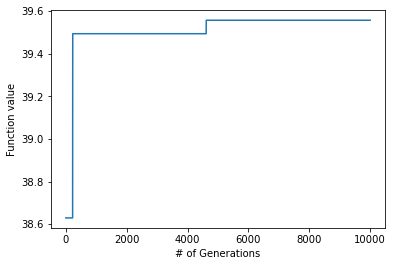

New best found at Generation 1 with value: 39.24921278275171
New best found at Generation 4 with value: 39.406232458491736
New best found at Generation 831 with value: 39.63130422670115


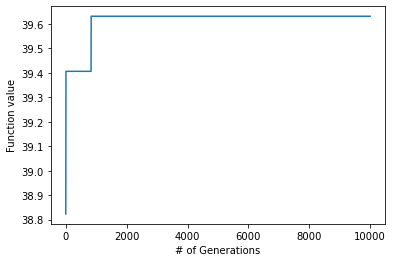

In [161]:
generations = 10000
popSize = 100
noImprovementMax = 10001

for i in range(5):
    ga = GeneticAlgorithm(constraints, precision,0.01,0.3,popSize,generations,noImprovementMax)
    ga.start()

In [164]:
iterations = np.array([5709,1977,7845,4612,831])
print(iterations.mean())

4194.8


We can see that no improvement is found after ~8049 iterations and that the optimal value found is not the best compared with other tests. Therefore, if I had to set a stopping criterion, it would be at 4194.8, but, in this case, we don't need a improvement stopping criterion as we can see in the first tests.